In [25]:
import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [120]:
df = pd.DataFrame()
df = pd.read_csv('may_june_july.csv', delimiter="|")
#ab = xy[:10]
#df = ab.copy()



In [121]:
# Combine all text
df['AllText'] = ""
df['primary_kw'].fillna(" ", inplace=True)
df['tags'].fillna(" ", inplace=True)
for i, row in df.iterrows():
    cv = df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,8]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    df.set_value(i,'AllText',cv)


In [122]:
df['Log'] = df['freq']*df['impressions']/1000
for i, row in df.iterrows():
    cv = math.log(df.iloc[i,12],2)
    df.set_value(i,'Log',cv)

9.97900229397
3.21629982395


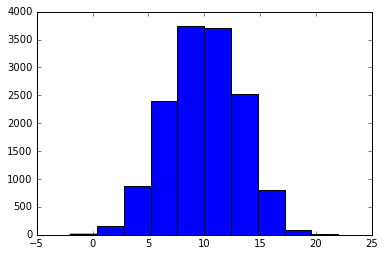

In [123]:
data_mean = df["Log"].mean()
print data_mean

data_std = df["Log"].std()
print data_std

%matplotlib inline
plt.hist(df["Log"])
plt.show()

In [124]:
df.shape

(14297, 13)

In [125]:
# Virality defined as -1 sigma from mean
df['viral'] = np.where(df['Log']<data_mean-data_std, 'notviral', 'viral')
df['viral_num'] = df.viral.map({'notviral':0, 'viral':1})
#df.head()

In [126]:
#df.tail()

In [127]:
df.shape

(14297, 15)

In [128]:
df.viral.value_counts()

viral       11862
notviral     2435
Name: viral, dtype: int64

In [129]:
X = df.AllText
y = df.viral_num
print(X.shape)
print(y.shape)

(14297,)
(14297,)


In [130]:
X.head()

0    Giant man with tiny dog alert! Celebrity The M...
1    FYI: Ice cream sandwiches &gt; all other sandw...
2    "My mama always said you can tell a lot about ...
3    Let's see if you're a true cheese whiz. Food C...
4    The EPA just released first-time guidelines on...
Name: AllText, dtype: object

In [131]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: viral_num, dtype: int64

In [132]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10722,)
(3575,)
(10722,)
(3575,)


In [143]:
# instantiate the vectorizer
# Test Following scenarions:  max_df=0.5
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_df=0.5)


In [144]:
#X_train

In [145]:
vect

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [146]:
# learn training data vocabulary, then use it to create a document-term matrix
# FOLLOWING CAN BE DONE IN SINGLE STEP:  X_train_dtm = vect.fit_transform(X_train)
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [147]:
X_train_dtm

<10722x15808 sparse matrix of type '<type 'numpy.int64'>'
	with 287918 stored elements in Compressed Sparse Row format>

In [148]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3575x15808 sparse matrix of type '<type 'numpy.int64'>'
	with 94428 stored elements in Compressed Sparse Row format>

In [149]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [150]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 9.81 ms, sys: 2.27 ms, total: 12.1 ms
Wall time: 10.2 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [151]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [152]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.81146853146853148

In [153]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 217,  406],
       [ 268, 2684]])

In [94]:
# print message text for the false positives (non-viral incorrectly classified as viral)
X_test[y_test < y_pred_class]

2356     So much fierce, so little time. Music Here's W...
4046     Robert Czegely has been accused of "gross misc...
3116     Put your JT fandom to the test. Music Are Thes...
1790     Do you read bad drawings? Animals Can You Iden...
1094     Hold the door. Culture 53 Thoughts I Had Watch...
3807     Three of the former Libyan dictator s top offi...
153      Seven police officers and two civilians were h...
2410     Tiny home, big clean. DIY 28 Clever Ways To De...
2813     Today's characters: the Malfoys. UK Here Are T...
4781     <b>These big rocks in the desert will blow you...
3312     For when you want a little bit of ~everything....
10363    Yes, I want my house to smell like fairy bread...
3895     "Next week will see the debut of Hodor's cousi...
4290     Some Bernie-or-Busters protested Clinton's spe...
1401     Underrated is an UNDERstatement. Rewind It's T...
11347    Put all those geography classes to the test. I...
1578     <b>Picture your favorite invention.</b> Now pi.

In [95]:
# print message text for the false negatives (Viral incorrectly classified as non-viral)
X_test[y_test > y_pred_class]

11141    Mmmmmmmmmmmmmmmm. India 16 Extremely Satisfyin...
12571    It wasn't. India 17 Things That Will Make Ever...
5558     "You're worthy of the last French fry in the b...
10655    Worse still, literally no one is surprised. In...
14152    In 2016, it takes staggering ignorance to thin...
2674     Your relationship with the word "home" becomes...
13227    "I am no longer okay with just being a sidekic...
11674    The school has thousands of students, no full-...
11436    "I have always said, I will work after marriag...
9034     TL;DR Poo is done with your shit. India Kareen...
5811     A hot new type of food stack. Food People On I...
1175     Give those old duds new life. DIY 18 No-Sew Wa...
3153     The pound may be weak, but the memes are stron...
6004     She was a better Trump than Trump. USNews Mery...
5640     Vote Leave, take back the status quo? UKNews F...
8943     "She just wakes up like that." India Aishwarya...
11646    Pappis for puppies. India 9 Pictures Of Doggie.

In [96]:
# example false negative
#X_test[3]

In [97]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.67990059,  0.99984685,  0.99999829, ...,  0.99999919,
        0.99999972,  0.99629517])

In [98]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.73614156085381088

In [99]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [100]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 658 ms, sys: 12 ms, total: 670 ms
Wall time: 673 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [101]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [102]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.8093811 ,  0.97096945,  0.98082109, ...,  0.98028302,
        0.99328703,  0.87609797])

In [103]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.82237762237762235

In [104]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.72488276849060629

In [105]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

15808

In [106]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

[u'00', u'000', u'007', u'00s', u'03', u'06', u'07', u'09', u'10', u'100', u'100000', u'100m', u'101', u'11', u'110', u'11th', u'12', u'125', u'129', u'13', u'14', u'140', u'143', u'15', u'150', u'1500', u'151', u'16', u'160', u'16_new_food', u'16th', u'17', u'172', u'177', u'1789', u'17th', u'18', u'182', u'18311', u'18th', u'19', u'1938922913', u'1950s', u'1955', u'1960s', u'1964', u'1966', u'1969', u'1970s', u'1972']


In [107]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

[u'zack', u'zackary', u'zafar', u'zafn', u'zaful', u'zag', u'zakia', u'zambia', u'zanada', u'zara', u'zaveri', u'zayn', u'zbych', u'zealand', u'zebra', u'zelda', u'zemeckis', u'zen', u'zendaya', u'zero', u'zesty', u'zeus', u'zhang', u'zhao', u'zig', u'zika', u'zinger', u'zip', u'zit', u'ziva', u'zo', u'zodiac', u'zodiacquiz', u'zoe', u'zoey', u'zombies', u'zone', u'zones', u'zoo', u'zoodles', u'zooey', u'zookeeper', u'zoom', u'zootopia', u'zoren', u'zucchini', u'zuchinni', u'zuckerberg', u'zwan', u'zz']


In [108]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  0.,   7.,   4., ...,   1.,   0.,   1.],
       [  4.,  40.,   4., ...,   2.,   3.,   1.]])

In [109]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 15808)

In [110]:
# number of times each token appears across all Non-viral Buzzes
non_viral_token_count = nb.feature_count_[0, :]
non_viral_token_count

array([ 0.,  7.,  4., ...,  1.,  0.,  1.])

In [111]:
# number of times each token appears across all Viral Buzzes
viral_token_count = nb.feature_count_[1, :]
viral_token_count

array([  4.,  40.,   4., ...,   2.,   3.,   1.])

In [112]:
# create a DataFrame of tokens with their separate non-viral and viral counts
tokens = pd.DataFrame({'token':X_train_tokens, 'non_viral':non_viral_token_count, 'viral':viral_token_count}).set_index('token')
tokens.head()

,non_viral,viral
token,,
00,0.0,4.0
000,7.0,40.0
007,4.0,4.0
00s,18.0,216.0
03,0.0,3.0


In [113]:
# examine 5 random DataFrame rows
tokens.sample(20, random_state=6)

,non_viral,viral
token,,
puff,0.0,10.0
canada,92.0,247.0
comtent,27.0,206.0
burnham,1.0,8.0
poops,2.0,1.0
surgery,5.0,14.0
crohns,0.0,2.0
strange,4.0,16.0
stray,1.0,1.0


In [114]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([ 1812.,  8910.])

In [115]:
# add 1 to non-viral and viral counts to avoid dividing by 0
tokens['non_viral'] = tokens.non_viral + 1
tokens['viral'] = tokens.viral + 1
tokens.sample(5, random_state=6)

,non_viral,viral
token,,
puff,1.0,11.0
canada,93.0,248.0
comtent,28.0,207.0
burnham,2.0,9.0
poops,3.0,2.0


In [116]:
# convert the non-viral and viral counts into frequencies
tokens['non_viral'] = tokens.non_viral / nb.class_count_[0]
tokens['viral'] = tokens.viral / nb.class_count_[1]
tokens.sample(5, random_state=6)

,non_viral,viral
token,,
puff,0.000552,0.001235
canada,0.051325,0.027834
comtent,0.015453,0.023232
burnham,0.001104,0.001010
poops,0.001656,0.000224


In [117]:
# calculate the ratio of viral-to-non-viral for each token
tokens['viral_ratio'] = tokens.viral / tokens.non_viral
tokens.sample(5, random_state=6)

,non_viral,viral,viral_ratio
token,,,
puff,0.000552,0.001235,2.237037
canada,0.051325,0.027834,0.542312
comtent,0.015453,0.023232,1.503463
burnham,0.001104,0.001010,0.915152
poops,0.001656,0.000224,0.135578


In [118]:
# examine the DataFrame sorted by viral_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('viral_ratio', ascending=False)

,non_viral,viral,viral_ratio
token,,,
petty,0.000552,0.007183,13.015488
stanford,0.001104,0.013917,12.608754
gym,0.000552,0.006846,12.405387
sims,0.000552,0.006510,11.795286
bra,0.000552,0.006510,11.795286
boobs,0.001104,0.012570,11.388552
yeah,0.000552,0.005051,9.151515
san,0.000552,0.004826,8.744781
spears,0.000552,0.004377,7.931313


In [119]:
# look up the viral_ratio for a given token
tokens.loc['stanford', 'viral_ratio']

12.608754208754208